In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import config
from utils import compute_frames

In [2]:
import torch
from torch.utils.data import Dataset

# History dataset generation

In [3]:
# load legal amazon limits
am_bounds = gpd.read_file(config.AMAZON_FRONTIER_DATA)

In [4]:
# load frames idx detail
frames_idx = pd.read_csv(config.TR_FRAMES_IDX, index_col=0)

In [5]:
# load frames deforestation area history
deforestation = pd.read_csv(config.TR_DEFORESTATION, index_col=0)
deforestation["quarter_date"] = pd.to_datetime(deforestation["quarter_date"])

## Create grid

In [6]:
# create limits history grid
time_grid = np.zeros((len(config.TIME_STEPS), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
for t, dt in enumerate(config.TIME_STEPS):
    defor_area = (
        deforestation[
            deforestation["quarter_date"] == dt
        ].set_index("frame_id")["area"] +\
        pd.Series(0, index=frames_idx.index)
    ).fillna(0)
    time_grid[t, :, :] = defor_area.values.reshape(time_grid[0, :, :].shape)

In [7]:
time_grid.shape

(28, 3004, 2332)

# Compute frame bundle

A bundle is square of unitary frames. The bundle formation process consists in iterating through the full image on both axis computing the frames corresponding to each iteration.

In [8]:
out_condition = "borders"  # deforestation | borders

bundle_step = 32
bundles = []
for ix in tqdm(list(range(frames_idx["x"].min(), frames_idx["x"].max()+1, bundle_step))):
    fx = ix + config.INPUT_BOXES_SIZE
    for iy in range(frames_idx["y"].min(), frames_idx["y"].max()+1, bundle_step):
        fy = iy + config.INPUT_BOXES_SIZE

        iframes = frames_idx[
            (frames_idx["x"] >= ix) & 
            (frames_idx["x"] < fx) &
            (frames_idx["y"] >= iy) &
            (frames_idx["y"] < fy)
        ]
        
        if out_condition == "borders":
            if iframes["in_borders"].mean() >= 0.5:  # condition: bundle has to be at least half inside borders
                bundles.append(iframes.index)
                
        elif out_condition == "deforestation":
            out_of_borders_frames = len(set(iframes.index) - set(deforestation["frame_id"].values))
            if out_of_borders_frames < len(iframes):  # condition: bundle has to contain  some deforestation
                bundles.append(iframes.index)        

100%|██████████| 94/94 [06:48<00:00,  4.34s/it]


In [9]:
# remove bundles that represent reduced regions
bundles = [b for b in bundles if (len(b)==len(bundles[0]))]

In [10]:
len(bundles)

4011

In [11]:
bundles[0]

Index([   992,    993,    994,    995,    996,    997,    998,    999,   1000,
         1001,
       ...
       147962, 147963, 147964, 147965, 147966, 147967, 147968, 147969, 147970,
       147971],
      dtype='int64', length=4096)

In [32]:
# generate region and check which bundles intersect
region = compute_frames(am_bounds.total_bounds, config.BOX_SIDE, 1500, 1600, 1500, 1600)

1720
1721
1722
1723
1724
1775
1776
1777
1778
1779


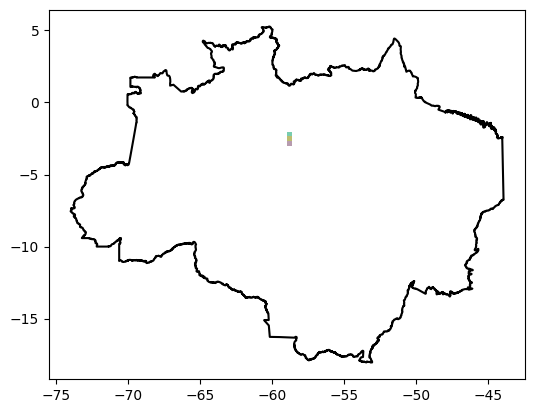

In [35]:
fig, ax = plt.subplots()
am_bounds.boundary.plot(ax=ax, color="black")
j = 0
for i, b in enumerate(bundles):
    int_b = region[region["frame_id"].isin(b)]
    if len(int_b) > 0:
        int_b.plot(ax=ax, color=sns.color_palette()[j%10], alpha=.5)
        j+=1
        if j > 10:
            break
        print(i)
plt.show()

# Create final matrix

In [36]:
class BinaryMatrixData:

    def __init__(self):
        pass

    def fit(self, X):
        self.X = X.copy()

        # apply (-1, 1) range
        self.X[np.where(X>=1e-7)] = 1
        self.X = 2*(self.X - .5)

        # normalize to get zero mean
        self.multiplier = (self.X<0).sum() / (self.X>0).sum()
        self.X[np.where(self.X == 1)] = self.multiplier

        return self.X

    def transform(self, X):
        X_ = X.copy()

        # apply (-1, 1) range
        X_[np.where(X_>=1e-7)] = 1
        X_ = 2*(X_ - .5)

        # normalize to get zero mean
        X_[np.where(X_ == 1)] = self.multiplier

        return X_

In [87]:
BMD = BinaryMatrixData()
train_data = BMD.fit(time_grid[-16:-4, :, :])
test_data = BMD.transform(time_grid[-8:, :, :])

# Dataset & Dataloaders

In [88]:
len(bundles) * (time_grid.shape[0] - 4)

96264

In [89]:
class CustomDataset(Dataset):
    def __init__(self, X, bundles, frames_idx):
        super(CustomDataset, self).__init__()

        self.bundles = bundles
        self.frames_idx = frames_idx
        self.X = X
        self.autor_window = 4
        self.ix = frames_idx["x"].min()
        self.iy = frames_idx["y"].min()

    def __len__(self):
        return len(self.bundles) * (self.X.shape[0]-self.autor_window)

    def __getitem__(self, index):
        idx_bundle = index // (self.X.shape[0] - self.autor_window)
        idx_time   = index % (self.X.shape[0] - self.autor_window)

        idx_frames = self.frames_idx.loc[self.bundles[idx_bundle]]

        data = torch.tensor(
            self.X[
                idx_time:idx_time+self.autor_window, 
                idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
            ]
        ).float()
        labels = torch.tensor(
            self.X[
                idx_time+self.autor_window, 
                idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
            ]
        ).float()
        return data, labels

In [90]:
train_data.shape, test_data.shape

((12, 3004, 2332), (8, 3004, 2332))

In [131]:
bundles_sample_train = [bundles[i] for i in np.random.choice(range(len(bundles)), 1000, replace=False)]
bundles_sample_test = [bundles[i] for i in np.random.choice(range(len(bundles)), 50, replace=False)]

In [132]:
trainloader = torch.utils.data.DataLoader(
    CustomDataset(train_data, bundles_sample_train, frames_idx),
    batch_size=10,
    shuffle=True
)

testloader = torch.utils.data.DataLoader(
    CustomDataset(test_data, bundles_sample_test, frames_idx),
    batch_size=1,
    shuffle=False
)

In [133]:
trainloader.__len__()*trainloader.batch_size, testloader.__len__()*testloader.batch_size

(8000, 200)

# Baseline Model

Just test the metrics we get when always predicting zeros.

In [134]:
# baseline: all -1
base_train_err = 0
for inputs, labels in trainloader:
    y_pred = torch.tensor(-np.ones(labels.shape))
    base_train_err -= (y_pred*labels).float().mean()
base_train_err = base_train_err / (len(trainloader)*trainloader.batch_size)
    
base_test_err = 0
for inputs, labels in testloader:
    y_pred = torch.tensor(-np.ones(labels.shape))
    base_test_err -= (y_pred*labels).float().mean()
base_test_err = base_test_err / (len(testloader)*testloader.batch_size)

print(f"Baseline: Train Loss = {base_train_err:.6f} | Test Loss = {base_test_err:.6f}")

Baseline: Train Loss = 0.046665 | Test Loss = 2.032997


In [135]:
# baseline: all 1
base_train_err = 0
for inputs, labels in trainloader:
    y_pred = torch.tensor(np.ones(labels.shape))
    base_train_err -= (y_pred*labels).float().mean()
base_train_err = base_train_err / (len(trainloader)*trainloader.batch_size)
    
base_test_err = 0
for inputs, labels in testloader:
    y_pred = torch.tensor(np.ones(labels.shape))
    base_test_err -= (y_pred*labels).float().mean()
base_test_err = base_test_err / (len(testloader)*testloader.batch_size)

print(f"Baseline: Train Loss = {base_train_err:.6f} | Test Loss = {base_test_err:.6f}")

Baseline: Train Loss = -0.046665 | Test Loss = -2.032997


# Model Implementation

In [136]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

ks = 9
 
class BasicConvModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.epoch = 0
        self.errs = []

        self.convolutional_layer = nn.Sequential(
            nn.Conv2d(4, 64, kernel_size=(ks,ks), stride=1, padding=int(ks/2)),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(ks,ks), stride=1, padding=int(ks/2)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(ks,ks), stride=1, padding=int(ks/2)),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 1, kernel_size=(ks,ks), stride=1, padding=int(ks/2)),
            nn.Tanh()
        )
 
    def forward(self, x):
        y = self.convolutional_layer(x)
        return y

In [137]:
# model initialization
model = BasicConvModel()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [138]:
print(model)

BasicConvModel(
  (convolutional_layer): Sequential(
    (0): Conv2d(4, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(9, 9), stride=1, padding=4, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 1, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (7): Tanh()
  )
)


In [139]:
for data, target in trainloader:
    break

In [140]:
data.shape, target.shape

(torch.Size([10, 4, 64, 64]), torch.Size([10, 64, 64]))

In [141]:
pred = model(data)

In [142]:
pred.shape, target.shape

(torch.Size([10, 1, 64, 64]), torch.Size([10, 64, 64]))

In [143]:
(pred[:, 0, :, :]*target).shape

torch.Size([10, 64, 64])

In [144]:
(pred[:, 0, :, :] - target).multiply(np.exp(target)).shape

C:\Users\GiovanniAmorim\AppData\Local\Temp\ipykernel_8832\327274672.py:1: RuntimeWarning: overflow encountered in exp
  (pred[:, 0, :, :] - target).multiply(np.exp(target)).shape


torch.Size([10, 64, 64])

In [145]:
# train loop
errs = []

def train(n_epochs):

    for epoch in range(n_epochs):
        print(f"\nEpoch {model.epoch}")
        if model.epoch >= 1:
            for inputs, labels in tqdm(trainloader):
                y_pred = model(inputs)[:, 0, :, :]
                # evaluate loss ignoring the borders
                # l = (y_pred - labels).multiply(np.exp(labels))
                l = -y_pred*labels
                loss = l.mean()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        train_err = 0
        for inputs, labels in trainloader:
            y_pred = model(inputs)[:, 0, :, :]
            # train_err += torch.square(y_pred - labels).detach().float().sum()
            train_err -= (y_pred * labels).detach().float().mean()
        train_err = train_err / (len(trainloader)*trainloader.batch_size)
            
        test_err = 0
        for inputs, labels in testloader:
            y_pred = model(inputs)[:, 0, :, :]
            # test_err += torch.square(y_pred - labels).detach().float().sum()
            test_err -= (y_pred * labels).detach().float().mean()
        test_err = test_err / len(testloader)
        model.errs.append([train_err, test_err])

        print(f"Epoch {model.epoch}: Train Loss = {train_err:.6f} | Test Loss = {test_err:.6f}")
        
        model.epoch += 1

train(10)


Epoch 0


Epoch 0: Train Loss = -0.025678 | Test Loss = -0.217205

Epoch 1


100%|██████████| 800/800 [26:07<00:00,  1.96s/it]


Epoch 1: Train Loss = -0.179315 | Test Loss = -1.808360

Epoch 2


100%|██████████| 800/800 [26:16<00:00,  1.97s/it]


Epoch 2: Train Loss = -0.181847 | Test Loss = -1.922892

Epoch 3


100%|██████████| 800/800 [25:28<00:00,  1.91s/it]


Epoch 3: Train Loss = -0.181929 | Test Loss = -1.959816

Epoch 4


100%|██████████| 800/800 [25:47<00:00,  1.93s/it]


Epoch 4: Train Loss = -0.183890 | Test Loss = -1.958060

Epoch 5


100%|██████████| 800/800 [25:24<00:00,  1.91s/it]


Epoch 5: Train Loss = -0.184888 | Test Loss = -2.061855

Epoch 6


100%|██████████| 800/800 [25:57<00:00,  1.95s/it]


Epoch 6: Train Loss = -0.185249 | Test Loss = -1.632721

Epoch 7


100%|██████████| 800/800 [25:37<00:00,  1.92s/it]


Epoch 7: Train Loss = -0.185294 | Test Loss = -1.528549

Epoch 8


100%|██████████| 800/800 [26:18<00:00,  1.97s/it]


Epoch 8: Train Loss = -0.185821 | Test Loss = -1.621461

Epoch 9


100%|██████████| 800/800 [25:44<00:00,  1.93s/it]


Epoch 9: Train Loss = -0.186358 | Test Loss = -1.593057


In [146]:
# train(30)

Ganhamos do baseline?

In [147]:
(
    float(model.errs[-1][0] - base_train_err), 
    float(model.errs[-1][1] - base_test_err)
)

(-0.13969330489635468, 0.43994009494781494)

Curva de aprendizado

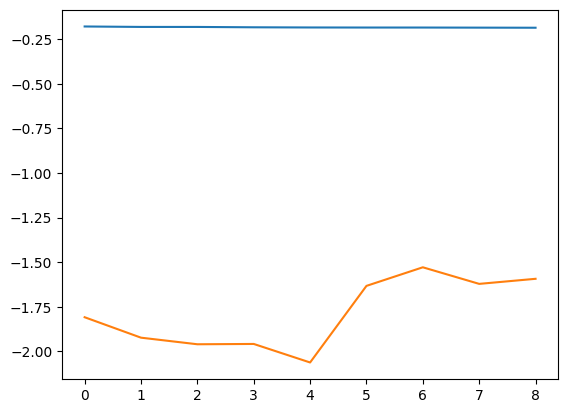

In [148]:
import matplotlib.pyplot as plt

plt.plot([float(e[0]) for e in model.errs][1:])
plt.plot([float(e[1]) for e in model.errs][1:])
plt.show()

Exemplo de previsão

In [154]:
region = compute_frames(am_bounds.total_bounds, config.BOX_SIDE, 1600, 1700, 1600, 1700)
t = 12

truth = time_grid[t, region["x"].min():region["x"].max()+1, region["y"].min():region["y"].max()+1]
input_ = time_grid[t-4:t, region["x"].min():region["x"].max()+1, region["y"].min():region["y"].max()+1]
input_ = input_.reshape(1,*input_.shape)
pred = model(torch.tensor(input_).float())[0, :, :].detach().numpy()

In [155]:
truth.min(), truth.max()

(0.0, 0.0988586994201317)

In [156]:
input_.shape

(1, 4, 100, 100)

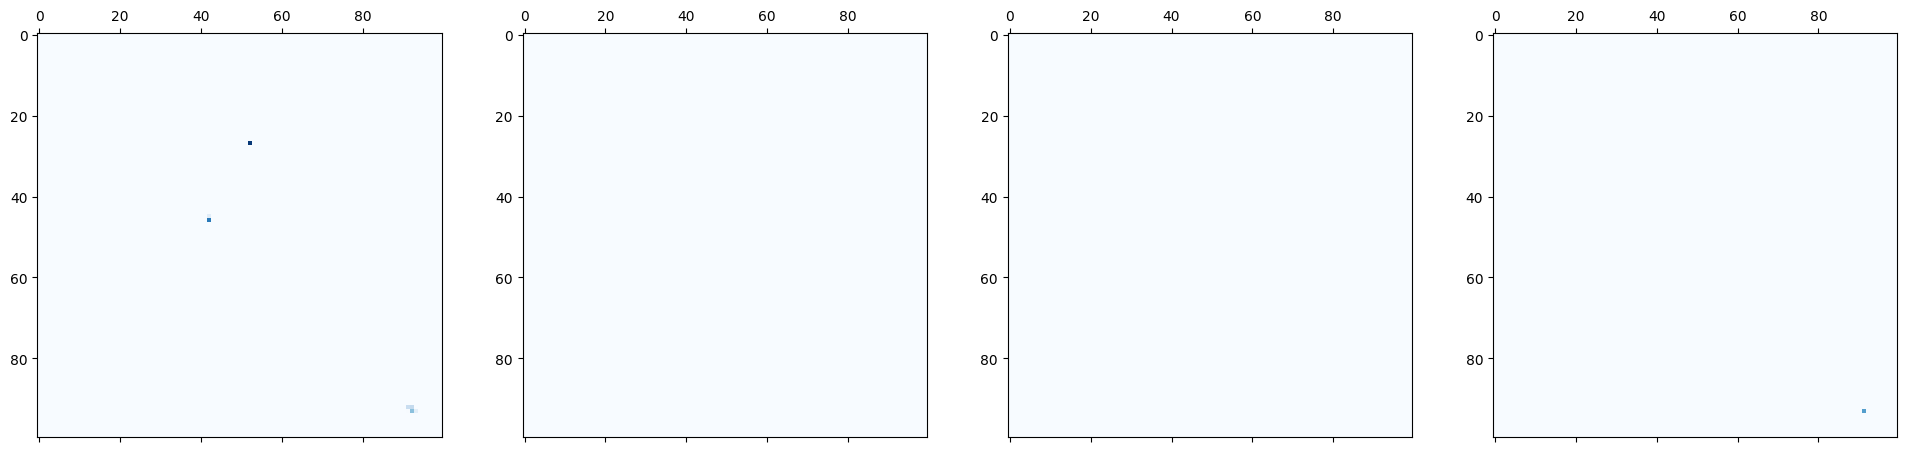

In [157]:
fig, ax = plt.subplots(1, 4, figsize=(24, 8))
for i in range(input_.shape[1]):
    ax[i].matshow(input_[0, i, :, :], cmap="Blues", vmin=truth.min(), vmax=truth.max())
plt.show()

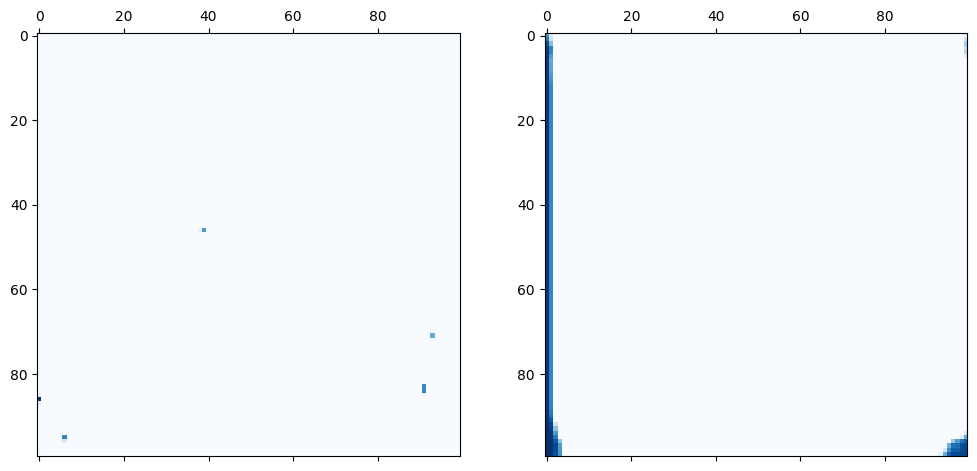

In [158]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
ax[0].matshow(truth, cmap="Blues", vmin=truth.min(), vmax=truth.max())
ax[1].matshow(pred[0, :, :], cmap="Blues", vmin=truth.min(), vmax=1)